[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

**notes**:
- "b" defined in eq. (18) lacks multiplication by $\rho_\text{s}$ - units do not match, plot matches the one generated with $\rho_\text{s}$ included - seems a typo in eq. (18)

**extentions (see notebook cells below first figure):**
- multiple isotopes (D, $^{18}$O, $^{17}$O)
- modern parameterisations: Horita & Wesolowski '94 for D & $^{18}$O equil. fractionation, Barkan & Luz '05 for $^{17}$O, Hellmann & Harvey '20 for diffusivities
- environment ratio plot axis
- temperature dependence

In [31]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [32]:
from PySDM.physics.constants import si, PER_MILLE, in_unit, PER_CENT
import copy
from types import SimpleNamespace
from matplotlib.lines import Line2D
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.dynamics.isotopic_fractionation import HEAVY_ISOTOPES

from PySDM import Builder
from PySDM.dynamics import Condensation, IsotopicFractionation
from PySDM.environments import Box
from PySDM.backends import CPU

#### derivations:

- Maxwell-Mason equation (introducing $\rho_\text{s}=\frac{p_\text{vs}}{R_\text{v}T}$, approximated for $S_\text{eq}\approx 1$ and taking into account $\frac{l_\text{v}}{R_\text{v} T} \approx 20 \gg 1$):
$$
a\frac{da}{dt} 
= f \frac{
    S - S_\text{eq}
}{
    \rho_w \left(
        \frac{R_\text{v} T }{\Psi p_\text{vs}(T)} + 
        \frac{l_\text{v}}{K T} \left(\frac{l_\text{v}}{R_\text{v} T}-1\right)
    \right)
}
\approx \frac{f}{\rho_\text{w}} \frac{S - 1}{        \frac{1}{\Psi \rho_\text{s}} + 
        \frac{l^2_\text{v}}{K R_v T^2}
}
= \frac{f \Psi \rho_\text{s}}{\rho_\text{w}} \frac{S - 1}{        1 + 
        \frac{\Psi \rho_\text{s} l^2_\text{v}}{K R_v T^2}
}
$$
where $t$ is time, $a$ is drop radius, $f$ is ventilation factor, $\Psi$ is mass diffusion coefficient, $K$ thermal diffusion coefficient, $l_\text{v}$ is latent heat of condensation, $R_\text{v}$ gas constant for water vapour, $T$ temperature, $\rho_\text{w}$ density of water, $\rho_\text{s}$ saturation vapour density.

In [33]:
CONST = Formulae().constants
print(f"lv/(Rv T) at the triple point: {CONST.l_tri / (CONST.Rv * CONST.T_tri):.3g}")
CONST = None

lv/(Rv T) at the triple point: 19.8


- expressed in terms of mass $m=\frac{4}{3}\pi a^3 \rho_\text{w}$:

$$\frac{dm}{dt} / [\text{surface}]
= \frac{d\left(\frac{4}{3}\pi a^3 \rho_\text{w}\right)}{dt} \frac{1}{4 \pi a^2}
= \rho_\text{w} \frac{da}{dt}
$$

- introducing $b=\frac{l^2_\text{v} \Psi}{K R_\text{v}T^2}$ and approximating leads to eq. (16) in the paper:

$$
\frac{dm}{dt} 
\approx 4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b \rho_\text{s}}
$$

In [34]:
class Commons:  # pylint: disable=too-few-public-methods
    """groups values used in both equations"""

    def __init__(self, **kwargs):
        self.formulae = kwargs["formulae"]
        const = self.formulae.constants
        self.vsmow_ratio = getattr(const, f'VSMOW_R_{kwargs["isotope"]}')
        self.iso_ratio_v = self.formulae.trivia.isotopic_delta_2_ratio(
            kwargs["delta_v"], self.vsmow_ratio
        )
        alpha_fun = getattr(
            self.formulae.isotope_equilibrium_fractionation_factors,
            f'alpha_l_{kwargs["isotope"]}',
        )
        if kwargs["isotope"] == "17O":
            alpha_l_18O = (
                self.formulae.isotope_equilibrium_fractionation_factors.alpha_l_18O(
                    kwargs["T"]
                )
            )
            self.alpha_w = alpha_fun(np.nan, alpha_l_18O)
        else:
            self.alpha_w = alpha_fun(kwargs["T"])

        self.diff_coef_ratio = 1 / getattr(
            self.formulae.isotope_diffusivity_ratios,
            f'ratio_{kwargs["isotope"]}_heavy_to_light',
        )(kwargs["T"])

        missing_b_multiplier = (
            self.formulae.saturation_vapour_pressure.pvs_water(kwargs["T"])
            / kwargs["T"]
            / const.Rv
        )
        self.b = (
            missing_b_multiplier
            * (self.formulae.latent_heat_vapourisation.lv(kwargs["T"]) / const.K0 - 1)
            * self.formulae.latent_heat_vapourisation.lv(kwargs["T"])
            * const.D0
            / const.Rv
            / kwargs["T"] ** 2
        )
        self.saturation_for_zero_dR_condition = (
            self.formulae.isotope_ratio_evolution.saturation_for_zero_dR_condition
        )
        any_number = 44.0
        self.vent_coeff_ratio = (
            self.formulae.isotope_ventilation_ratio.ratio_heavy_to_light(
                ventilation_coefficient=any_number,
                diffusivity_ratio_heavy_to_light=self.diff_coef_ratio,
            )
        )
        
        self.iso_ratio_liq_eq = self.alpha_w * self.iso_ratio_v


class NoFractionationSaturation:  # pylint: disable=too-few-public-methods
    """embodies eqs. (22) an (23) from the paper"""

    def __init__(self, cmn: Commons, *, liquid: bool = False, vapour: bool = False):
        assert liquid != vapour
        self.liquid = liquid
        self.cmn = cmn

    def __call__(self, iso_ratio_r):
        return self.cmn.saturation_for_zero_dR_condition(
            iso_ratio_x=iso_ratio_r if self.liquid else self.cmn.iso_ratio_v,
            diff_rat_light_to_heavy=self.cmn.vent_coeff_ratio
            * self.cmn.diff_coef_ratio,
            b=self.cmn.b,
            alpha_w=self.cmn.alpha_w,
            iso_ratio_r=iso_ratio_r,
            iso_ratio_v=self.cmn.iso_ratio_v,
        )


class Settings:
    @staticmethod
    def make_particulator(
        *,
        formulae,
        molecular_R_liq,
        initial_R_vap,
        attributes=None,
        n_sd=1,
        dv: float = np.nan,
        dt: float = -1 * si.s,
        RH: float = 1,
        T: float = 1,
    ):
        const = formulae.constants
        attributes["moles_2H"] = formulae.trivia.moles_heavy_atom(
            mass_total=attributes["signed water mass"],
            mass_other_heavy_isotopes=0,
            molar_mass_light_molecule=const.M_1H2_16O,
            molar_mass_heavy_molecule=const.M_2H_1H_16O,
            molecular_isotope_ratio=molecular_R_liq,
            atoms_per_heavy_molecule=1,
        )
        builder = Builder(
            n_sd=n_sd,
            backend=CPU(
                formulae=formulae,
            ),
            environment=Box(dv=dv, dt=dt),
        )
        builder.add_dynamic(Condensation())
        builder.add_dynamic(IsotopicFractionation(isotopes=("2H",)))

        builder.particulator.environment["RH"] = RH
        builder.particulator.environment["T"] = T
        rho_d = const.p_STP / const.Rd / T
        builder.particulator.environment["dry_air_density"] = rho_d

        initial_conc_vap = (
            formulae.saturation_vapour_pressure.pvs_water(T) * RH / const.R_str / T
        )

        molar_mixin_ratio_2H = (
            formulae.trivia.R_vap_to_molar_mixing_ratio_assuming_single_heavy_isotope(
                R_vap=initial_R_vap,
                density_dry_air=rho_d,
                conc_vap_total=initial_conc_vap,
            )
        )

        for isotope in HEAVY_ISOTOPES:
            if isotope == "2H":
                builder.particulator.environment[f"molar mixing ratio {isotope}"] = (
                    molar_mixin_ratio_2H
                )
            else:
                builder.particulator.environment[f"molar mixing ratio {isotope}"] = 0
        builder.request_attribute("delta_2H")
        return builder.build(attributes=attributes, products=())

    @staticmethod
    def do_one_step(*, formulae, particulator, evaporated_mass_fraction):
        initial_conc_vap = (
            formulae.saturation_vapour_pressure.pvs_water(
                particulator.environment["T"][0]
            )
            * particulator.environment["RH"][0]
            / formulae.constants.R_str
            / particulator.environment["T"][0]
        )
        initial_R_vap = (
            formulae.trivia.molar_mixing_ratio_to_R_vap_assuming_single_heavy_isotope(
                molar_mixing_ratio=particulator.environment["molar mixing ratio 2H"][0],
                density_dry_air=particulator.environment["dry_air_density"][0],
                conc_vap_total=initial_conc_vap,
            )
        )
        initial_R_liq = (
            particulator.attributes["moles_2H"][0]
            / particulator.attributes["moles_1H"][0]
        )

        dm = -evaporated_mass_fraction * (
            particulator.attributes["signed water mass"][0]
            * particulator.attributes["multiplicity"][0]
        )
        particulator.attributes["diffusional growth mass change"].data[0] = (
            dm / particulator.attributes["multiplicity"]
        )
        assert np.all(
            particulator.attributes["diffusional growth mass change"].data < 0
        )

        particulator.dynamics["IsotopicFractionation"]()

        new_R_vap = (
            formulae.trivia.molar_mixing_ratio_to_R_vap_assuming_single_heavy_isotope(
                molar_mixing_ratio=particulator.environment[
                    "molar mixing ratio 2H"
                ].data[0],
                density_dry_air=particulator.environment["dry_air_density"][0],
                conc_vap_total=initial_conc_vap
                - dm / formulae.constants.Mv / particulator.environment.mesh.dv,
            )
        )
        new_R_liq = (
            particulator.attributes["moles_2H"][0]
            / particulator.attributes["moles_1H"][0]
        )
        dR_vap = new_R_vap - initial_R_vap
        dR_liq = new_R_liq - initial_R_liq
        return dR_vap / initial_R_vap, dR_liq / initial_R_liq

In [35]:
paper_params = SimpleNamespace(
    formulae=Formulae(
        isotope_equilibrium_fractionation_factors='MerlivatAndNief1967',
        isotope_relaxation_timescale='ZabaEtAl',
        isotope_diffusivity_ratios='Stewart1975',
        isotope_ratio_evolution='GedzelmanAndArnold1994',
        isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
        drop_growth="Mason1971",
    ),
    isotope='2H',
    delta_v= -200 * PER_MILLE,
    xlim=(.8, 1),
    RH_unit=PER_CENT
)
K2C = paper_params.formulae.trivia.K2C
C2K = paper_params.formulae.trivia.C2K
paper_params.T = C2K(10) * si.K
T_range = (C2K(-10) * si.K, C2K(30) * si.K)
Ts = np.linspace(*T_range, 9)

BASE_INITIAL_ATTRIBUTES = {
    "dry volume": np.nan,
    "kappa times dry volume": np.nan,
    **{f"moles_{isotope}": 0 * si.mole for isotope in HEAVY_ISOTOPES},
}
COMMONS = Commons(**vars(paper_params))

In [36]:

def plot(*, fig, ax, x, ys, xlim, params: SimpleNamespace):
    temp_01 = (params.T - T_range[0])/(T_range[1] - T_range[0])
    color = (temp_01, .333, 1-temp_01)
    iso_latex = f"^{{{params.isotope[:-1]}}}{params.isotope[-1]}"
    for i, y, label in zip((0, 1), ys, [(r'S$_R$(eq)'), (r'S$_V$(eq)')]):
        if len(fig.axes)==1:
            ax.plot(x, y, label=label, color=color)
        else:
            ax[i].plot(x, y, label=label, color=color)
        
        
    fig.gca().set(
        title=f"ambient vapour $\\delta{iso_latex}$ = {in_unit(params.delta_v, PER_MILLE):.3g}‰",
        ylim=(0, 1),
        yticks=np.linspace(0, 1, 5),
        xlabel=f'${iso_latex}$: R$_{{rain}}$ / R$_{{SMOW}}$',
        ylabel='S=RH',
        xlim=xlim,
    )
    fig.gca().grid(visible=True, axis='both')

    
    return x, {'eq_22': y_eq_22, 'eq_23': y_eq_23}

/var/folders/gl/1t3c1h9x3ws6d68b11gr2rth0000gn/T/ipykernel_85671/625741028.py:161: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  particulator.attributes["diffusional growth mass change"].data[0] = (


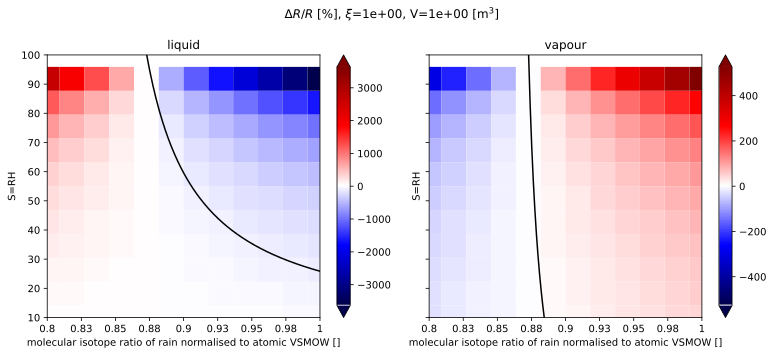

In [37]:
PLOT_PARAMS = SimpleNamespace(
    grid=(12, 12),
    ylim=(0.1, 1),
    figsize=(11, 5)
)
params = copy.deepcopy(paper_params)
def calculate_relative_ratio_change(relative_humidity, molecular_R_liq, formulae, attributes, cmn, volume, n_sd, T, evaporated_mass_fraction):
    
    rel_diff_vap = np.zeros((len(relative_humidity), len(molecular_R_liq)))
    rel_diff_liq = np.zeros_like(rel_diff_vap)
    for i, rh in enumerate(relative_humidity):
        for j, m_R_liq in enumerate(molecular_R_liq):
            particulator = Settings.make_particulator(
                    RH=rh,
                    molecular_R_liq=m_R_liq,
                    formulae=formulae,
                    attributes=attributes,
                    initial_R_vap=cmn.iso_ratio_v,
                    dv=volume,
                    n_sd=n_sd,
                    T=T,
                )
            rel_diff_vap[i, j], rel_diff_liq[i, j] = Settings.do_one_step(
                formulae=formulae,
                particulator=particulator,
                evaporated_mass_fraction=evaporated_mass_fraction,
            )
    return (
        rel_diff_vap,
        rel_diff_liq,
    )
cmn = Commons(**vars(params))
phases = ["liquid", "vapour"]
x = np.linspace(cmn.iso_ratio_liq_eq / cmn.vsmow_ratio, 1.1, 200)

S_eq = {
    "liquid": NoFractionationSaturation(cmn, liquid=True)(x * cmn.vsmow_ratio),
    "vapour": NoFractionationSaturation(cmn, vapour=True)(x * cmn.vsmow_ratio)
}
formulae = cmn.formulae
multiplicity = 1
const = formulae.constants
pp=PLOT_PARAMS
molecular_R_liq = np.linspace(0.8, 1, pp.grid[0]) * const.VSMOW_R_2H
volume=1 * si.m**3
RH = np.linspace(*pp.ylim, pp.grid[1])
liquid_water_content=1 * si.g / si.m**3
attributes = BASE_INITIAL_ATTRIBUTES.copy()
attributes["multiplicity"] = np.ones(1)
attributes["signed water mass"] = liquid_water_content * volume / attributes["multiplicity"]

s_eq = {
    "liquid": NoFractionationSaturation(cmn, liquid=True)(molecular_R_liq),
    "vapour": NoFractionationSaturation(cmn, vapour=True)(molecular_R_liq)
}
(rel_diff_vap, rel_diff_liq) = calculate_relative_ratio_change(relative_humidity=RH, molecular_R_liq=molecular_R_liq, formulae=formulae, attributes=attributes, cmn=cmn, volume=1 * si.m**3, n_sd=1, T=params.T, evaporated_mass_fraction=0.02)

mesh_grid = np.meshgrid(molecular_R_liq / const.VSMOW_R_2H,
                in_unit(RH, params.RH_unit))
rh_percent = in_unit(RH, params.RH_unit)
fig, ax = pyplot.subplots(1, 2, figsize=PLOT_PARAMS.figsize, sharex=True, sharey=True)
fig.suptitle(f"$\\Delta R/R$ [%], $\\xi$={multiplicity:.0e}, V={volume:.0e} [m$^3$]")
for idx, data in enumerate((rel_diff_liq, rel_diff_vap)):
    pcm = ax[idx].pcolormesh(
        molecular_R_liq / const.VSMOW_R_2H,
        in_unit(RH, params.RH_unit),
        data_percent := in_unit(data, PER_CENT),
        cmap="seismic",
        vmax=(vmax := np.nanmax(np.abs(data_percent))),
        vmin=-vmax,
    )
    fig.colorbar(pcm, ax=ax[idx], extend="both")
    ax[idx].plot(x, in_unit(S_eq[phases[idx]], params.RH_unit), c='k')
    ax[idx].set(
        title=f"{phases[idx]}",
        xlim=params.xlim,
        ylim=(in_unit(pp.ylim[0], params.RH_unit), in_unit(pp.ylim[1], params.RH_unit)),
        ylabel="S=RH",
        xlabel="molecular isotope ratio of rain normalised to atomic VSMOW []",
    )
pyplot.tight_layout()
pyplot.gca().xaxis.set_major_formatter('{x:.2g}')
show_plot("R_ratios_for_liquid_and_vapour")


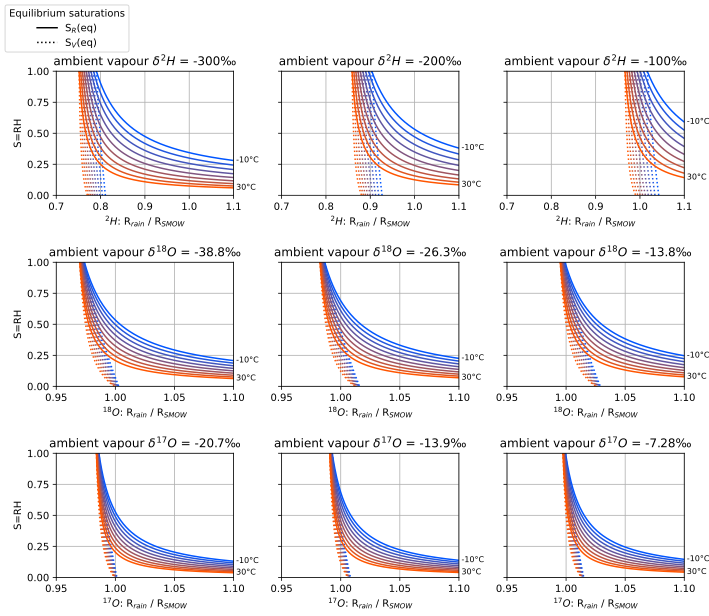

In [38]:
params = copy.deepcopy(paper_params)
params.formulae = Formulae(
    isotope_equilibrium_fractionation_factors='BarkanAndLuz2005+HoritaAndWesolowski1994',
    isotope_diffusivity_ratios='HellmannAndHarvey2020',
    isotope_meteoric_water_line='BarkanAndLuz2007+Dansgaard1964',
    isotope_ratio_evolution='GedzelmanAndArnold1994',
    isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
)
iso_mwl=params.formulae.isotope_meteoric_water_line
deltas_2H = (-300 * PER_MILLE, -200 * PER_MILLE, -100 * PER_MILLE)
deltas_18O = [iso_mwl.d18O_of_d2H(d2H) for d2H in deltas_2H]
deltas_17O = [iso_mwl.d17O_of_d18O(d18O) for d18O in deltas_18O]

plot_params = {
    'liquid': {'label': 'S$_R$(eq)', 'linestyle':'-'},
    'vapour': {'label': 'S$_V$(eq)', 'linestyle':':'},
}
fig, axs = pyplot.subplots(3, 3, figsize=(10,8), sharex=False, sharey=True) 
x_lim = {
    '2H': (.7, 1.1),
    '18O': (.95, 1.1),
    '17O': (.95, 1.1),
}
for ax_idx_iso, iso_label in enumerate(('2H', '18O', '17O')):
    x_lim_iso=x_lim[iso_label]
    for ax_idx_delta, delta_v in enumerate({
        '2H': deltas_2H,
        '18O': deltas_18O,
        '17O': deltas_17O,
    }[iso_label]):
        params.delta_v = delta_v
        params.isotope = iso_label
        ax=axs[ax_idx_iso][ax_idx_delta]
        for i, temperature in enumerate(Ts):
            params.T = temperature
            commons = Commons(**vars(params))
            x = np.linspace(commons.alpha_w * commons.iso_ratio_v / commons.vsmow_ratio, 1.1, 200)
            y_eq_liq = NoFractionationSaturation(commons, liquid=True)(x * commons.vsmow_ratio)
            y_eq_vap = NoFractionationSaturation(commons, vapour=True)(x * commons.vsmow_ratio)
            temp_01 = (params.T - T_range[0])/(T_range[1] - T_range[0])
            color = (temp_01, .333, 1-temp_01)
            iso_latex = f"^{{{params.isotope[:-1]}}}{params.isotope[-1]}"
            if i==0 or i==len(Ts)-1:
                axs[ax_idx_iso][ax_idx_delta].annotate(
                    f' {K2C(params.T):g}°C$\\!\\!\\!\\!\\!\\!$',
                    (x_lim_iso[-1], y_eq_liq[-1] - .015),
                    fontsize=8
                )
            for y, p in zip((y_eq_liq, y_eq_vap), (plot_params['liquid'], plot_params['vapour'])):
                ax.plot(x, y, color=color, linestyle=p['linestyle'])  
        ax.set(
            title=f"ambient vapour $\\delta{iso_latex}$ = {in_unit(params.delta_v, PER_MILLE):.3g}‰",
            ylim=(0, 1),
            yticks=np.linspace(0, 1, 5),
            xlabel=f'${iso_latex}$: R$_{{rain}}$ / R$_{{SMOW}}$',
            ylabel='S=RH',
            xlim=x_lim[iso_label],
        )
        ax.grid(True)
        if ax_idx_delta != 0:
            axs[ax_idx_iso][ax_idx_delta].set_ylabel('')

legend_lines = [
    Line2D([0], [0], color='black', linestyle=plot_params['liquid']['linestyle'], label='S$_R$(eq)'),
    Line2D([0], [0], color='black', linestyle=plot_params['vapour']['linestyle'], label='S$_V$(eq)'),
]

fig.legend(legend_lines, (l.get_label() for l in legend_lines),
           loc='upper left',
           title="Equilibrium saturations")

fig.tight_layout()
fig.subplots_adjust(top=0.88, bottom=0)
show_plot('plot_grid.pdf')